Packages

In [94]:
#modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras

#configuration
pd.set_option('display.max_columns', None)

Extracting Data from csvs and turning into Pandas Data frame

In [95]:
oil = pd.read_csv("data/oil.csv")
holidays = pd.read_csv("data/holidays_events.csv")
stores = pd.read_csv("data/stores.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
transactions = pd.read_csv("data/transactions.csv")

transactions.sort_values(['store_nbr', 'date'])

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83271,2017-08-11,54,768
83325,2017-08-12,54,903
83379,2017-08-13,54,1054
83433,2017-08-14,54,818


Checking dataframe heads

In [96]:
print(oil.head())
print(holidays.head())
print(stores.head())
print(test.head())
print(train.head())
print(transactions.head())

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                  

Convert date columns in dataframe to date time format

In [97]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])

Check for NaN Values

In [98]:
print(oil.isna().sum())
print(holidays.isna().sum())
print(stores.isna().sum())
print(test.isna().sum())
print(train.isna().sum())
print(transactions.isna().sum())

date           0
dcoilwtico    43
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64


Print Oil data frame and replace NaN values with next day oil price

        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
1218


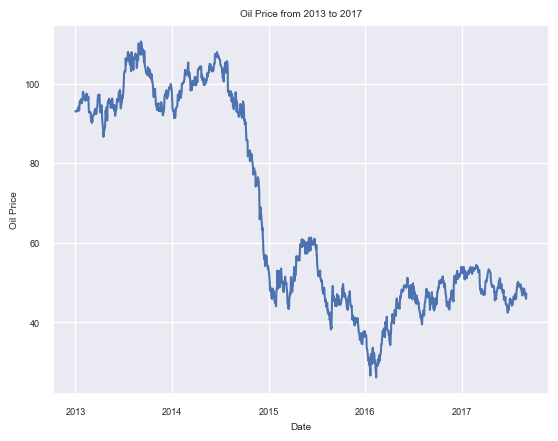

In [99]:
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(limit_direction="both")
print(oil.head())
print(len(oil))
oil = oil.set_index("date")
plt.plot(oil)
plt.title("Oil Price from 2013 to 2017")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()

Create a function that label encodes all str type columns like holiday, store type, etc.

In [100]:
def label_encode_column(data):
    data = data.dropna()
    unique_values = data.unique()
    mapping = {value: i + 1 for i, value in enumerate(unique_values)}
    data_encoded = data.map(mapping)
    print(mapping)
    return data_encoded
#testing on holiday dataframe
holidays['type'] = label_encode_column(holidays['type'])
holidays.head()
#Holiday type notes
#Holiday transfer column is a boolean which represents if the holiday was moved to a different day or not
#Additional means that there are extra days added to a holiday (Christmas eve is an additional day as it is not christmas but also considered a holiday)
#Bridge represents if it is an extra day added to a holiday
#work day is a day where work is not usually expected (like saturday) but required to work to account for the extended bridge day

{'Holiday': 1, 'Transfer': 2, 'Additional': 3, 'Bridge': 4, 'Work Day': 5, 'Event': 6}


,date,type,locale,locale_name,description,transferred
0,2012-03-02,1,Local,Manta,Fundacion de Manta,False
1,2012-04-01,1,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,1,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,1,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,1,Local,Riobamba,Cantonizacion de Riobamba,False


In [101]:
stores['type'] = label_encode_column(stores['type'])
train['family'] = label_encode_column(train['family'])
stores['city'] = label_encode_column(stores['city'])
holidays['locale'] = label_encode_column(holidays['locale'])
holidays['locale_name'] = label_encode_column(holidays['locale_name'])
holidays['transferred'] = label_encode_column(holidays['transferred'])

{'D': 1, 'B': 2, 'C': 3, 'E': 4, 'A': 5}
{'AUTOMOTIVE': 1, 'BABY CARE': 2, 'BEAUTY': 3, 'BEVERAGES': 4, 'BOOKS': 5, 'BREAD/BAKERY': 6, 'CELEBRATION': 7, 'CLEANING': 8, 'DAIRY': 9, 'DELI': 10, 'EGGS': 11, 'FROZEN FOODS': 12, 'GROCERY I': 13, 'GROCERY II': 14, 'HARDWARE': 15, 'HOME AND KITCHEN I': 16, 'HOME AND KITCHEN II': 17, 'HOME APPLIANCES': 18, 'HOME CARE': 19, 'LADIESWEAR': 20, 'LAWN AND GARDEN': 21, 'LINGERIE': 22, 'LIQUOR,WINE,BEER': 23, 'MAGAZINES': 24, 'MEATS': 25, 'PERSONAL CARE': 26, 'PET SUPPLIES': 27, 'PLAYERS AND ELECTRONICS': 28, 'POULTRY': 29, 'PREPARED FOODS': 30, 'PRODUCE': 31, 'SCHOOL AND OFFICE SUPPLIES': 32, 'SEAFOOD': 33}
{'Quito': 1, 'Santo Domingo': 2, 'Cayambe': 3, 'Latacunga': 4, 'Riobamba': 5, 'Ibarra': 6, 'Guaranda': 7, 'Puyo': 8, 'Ambato': 9, 'Guayaquil': 10, 'Salinas': 11, 'Daule': 12, 'Babahoyo': 13, 'Quevedo': 14, 'Playas': 15, 'Libertad': 16, 'Cuenca': 17, 'Loja': 18, 'Machala': 19, 'Esmeraldas': 20, 'Manta': 21, 'El Carmen': 22}
{'Local': 1, 'Regional'

Merge data frames into one training dataframe with oil prices, holidays, transactions and stores for training


In [102]:
training = pd.merge(train, oil, how = 'left', on='date')
training = pd.merge(training, holidays, how = 'left',on = 'date')
training = pd.merge(training, transactions, how ='left', on =['date','store_nbr'])
training = pd.merge(training, stores, how = 'left', on = 'store_nbr')
training.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace = True)
training.head()

In [ ]:
training.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       878526
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
transactions     249117
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

Fill NaN values for necessary dataframe columns

In [ ]:
training[['holiday_type']] = training[['holiday_type']].fillna(0)
training['transactions']=training['transactions'].fillna(0)
training['dcoilwtico']=training['dcoilwtico'].fillna(method='bfill')
training['locale_name']= training['locale_name'].fillna(0)
training.isna().sum()

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\1053474950.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training['dcoilwtico']=training['dcoilwtico'].fillna(method='bfill')


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico            0
holiday_type          0
locale          2551824
locale_name           0
description     2551824
transferred     2551824
transactions          0
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

Continue to analyze and plot sales vs different features to see which features to keep for training the model

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\769906487.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=filtered_training, x='date', y='sales', hue='holiday_type', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

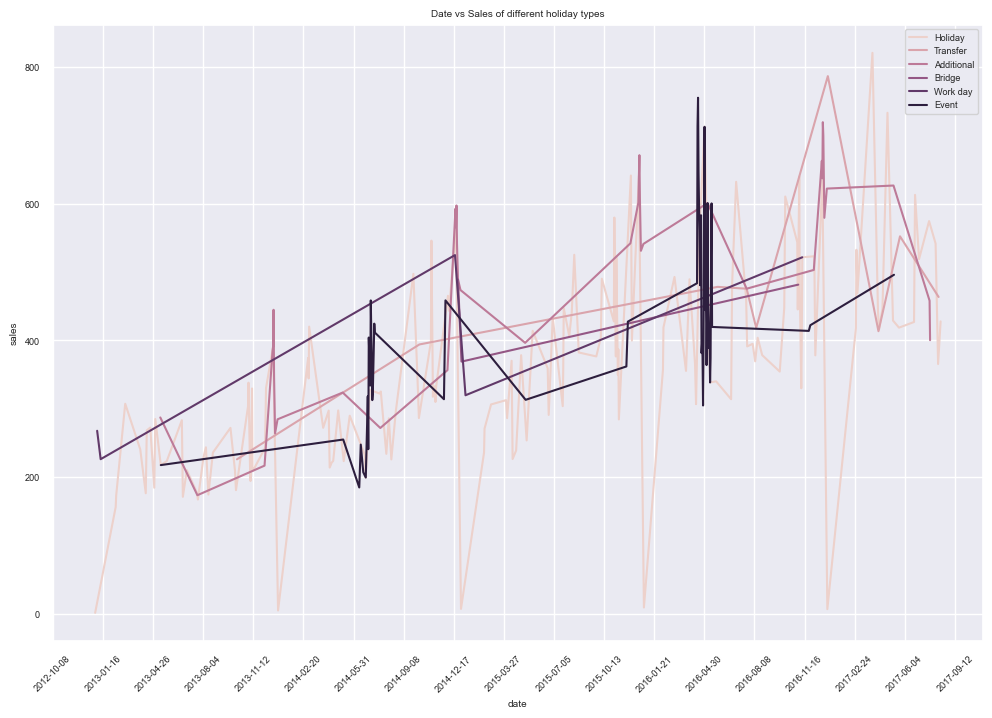

In [ ]:
# Filter the DataFrame to exclude rows where holiday_type is 0 (no holiday type just a normal day)
filtered_training = training[training['holiday_type'] != 0]

plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=filtered_training, x='date', y='sales', hue='holiday_type', ci = None)
start, end = ax.get_xlim()
ax.set_xticks(np.arange(start, end, 100))
plt.xticks(rotation=45)
plt.title("Date vs Sales of different holiday types")
plt.legend(["Holiday", "Transfer", 'Additional', "Bridge", "Work day", "Event"])
plt.show()
#{'Holiday': 1, 'Transfer': 2, 'Additional': 3, 'Bridge': 4, 'Work Day': 5, 'Event': 6}

Plotting Date vs Sales

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\2008448059.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data = training, x = 'date', y = 'sales', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert i

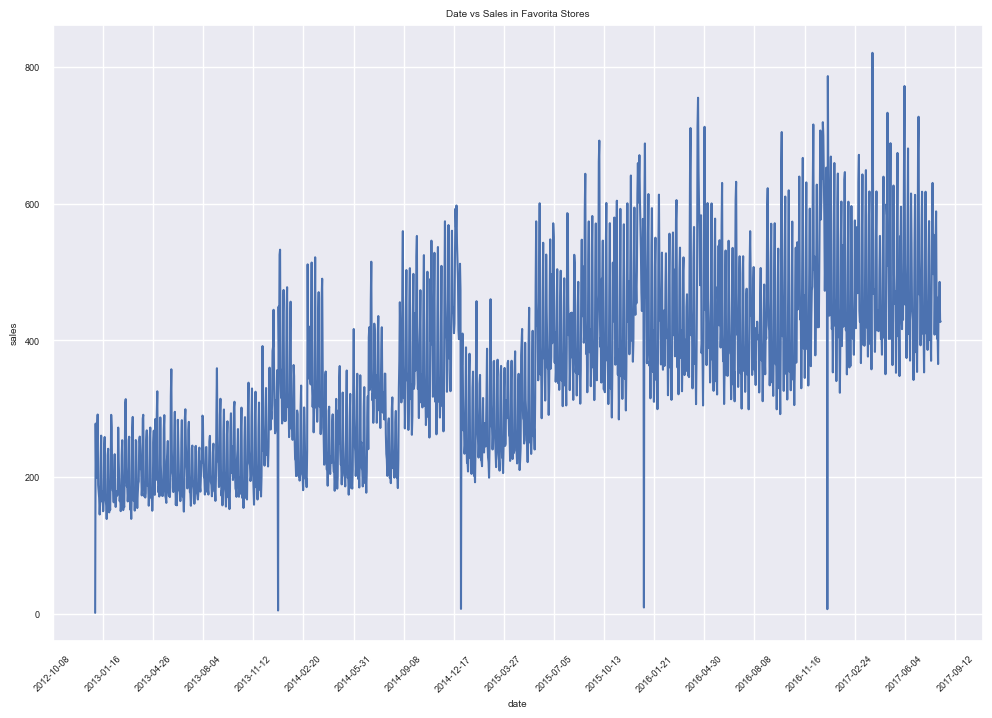

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.lineplot(data = training, x = 'date', y = 'sales', ci = None)
start, end = ax.get_xlim()
ax.set_xticks(np.arange(start, end, 100))
plt.xticks(rotation = 45)
plt.title("Date vs Sales in Favorita Stores")
plt.show()

Plotting Oil Vs Sales

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\1652301571.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data = training, x = 'dcoilwtico', y = 'sales', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Con

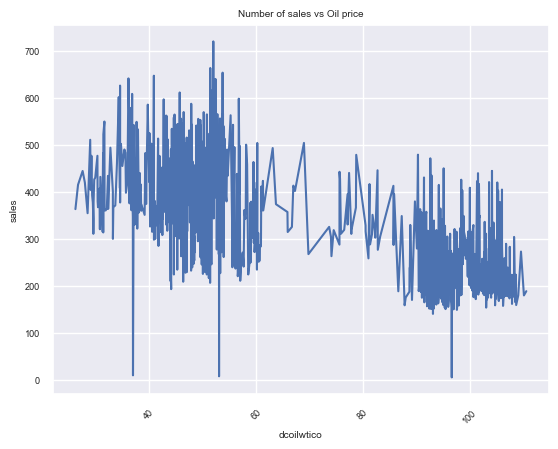

In [ ]:
ax = sns.lineplot(data = training, x = 'dcoilwtico', y = 'sales', ci = None)
plt.xticks(rotation = 45)
plt.title("Number of sales vs Oil price")
plt.show()
#Low oil price = higher sales, high oil price = lower sales

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\4242722975.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data = training, x = 'locale', y = 'sales', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

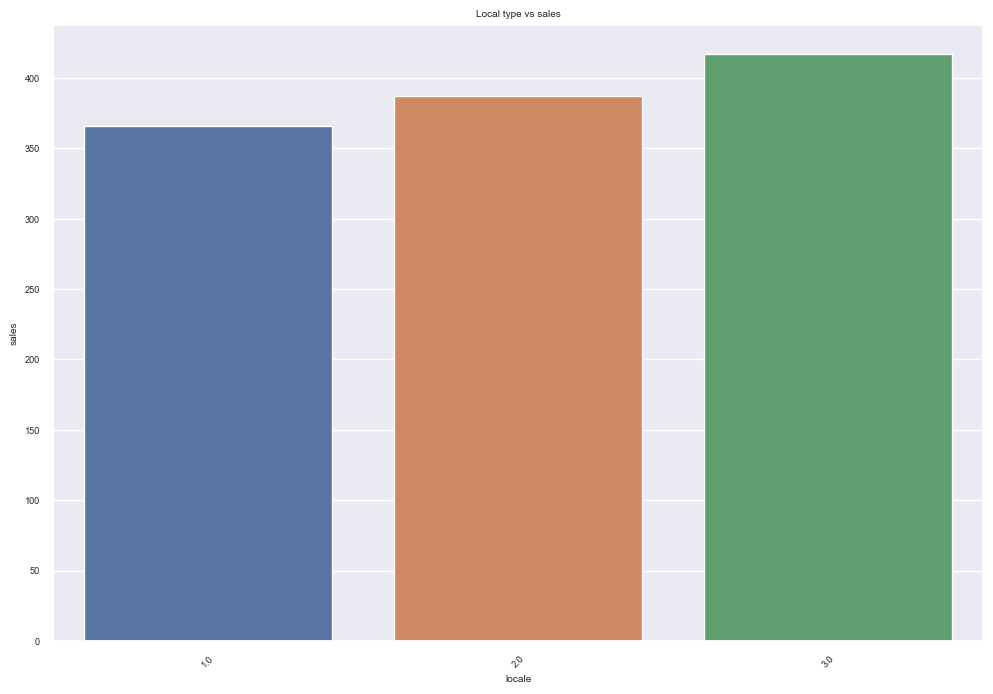

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'locale', y = 'sales', ci = None)
plt.xticks(rotation = 45)
plt.title("Local type vs sales")
plt.show()

holiday type vs sales

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\3803587147.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data = training, x = 'holiday_type', y = 'sales', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Us

Text(0.5, 1.0, 'Holiday types vs sales')

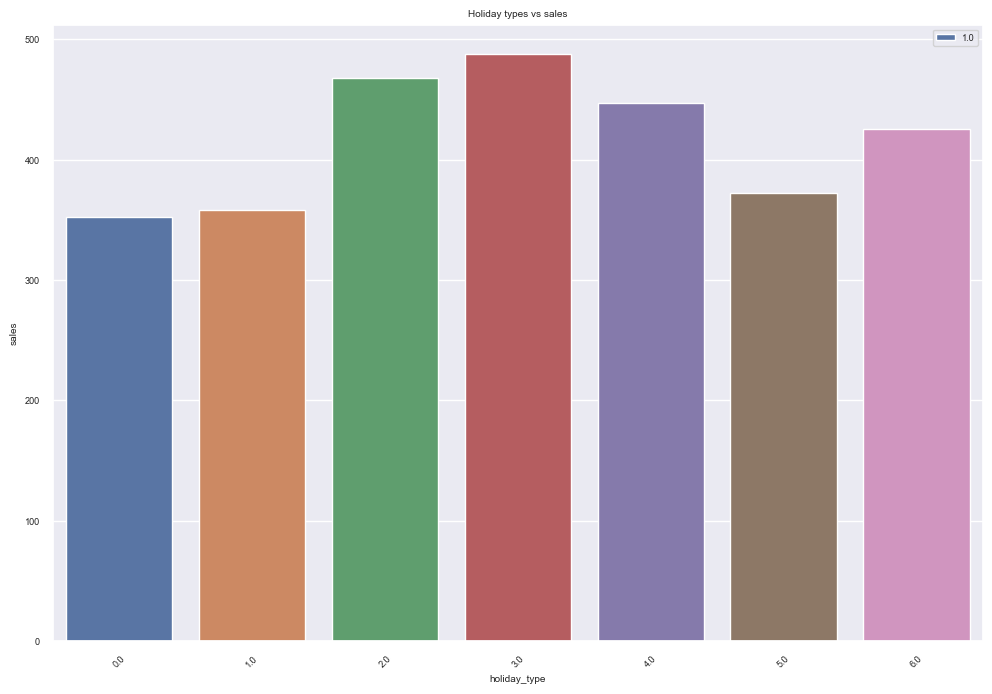

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'holiday_type', y = 'sales', ci = None)
plt.xticks(rotation = 45)
plt.title("Holiday types vs sales")

clusters vs sales

C:\Users\Eric\AppData\Local\Temp\ipykernel_24892\2013482067.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data = training, x = 'cluster', y = 'sales', ci = None)
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17')])

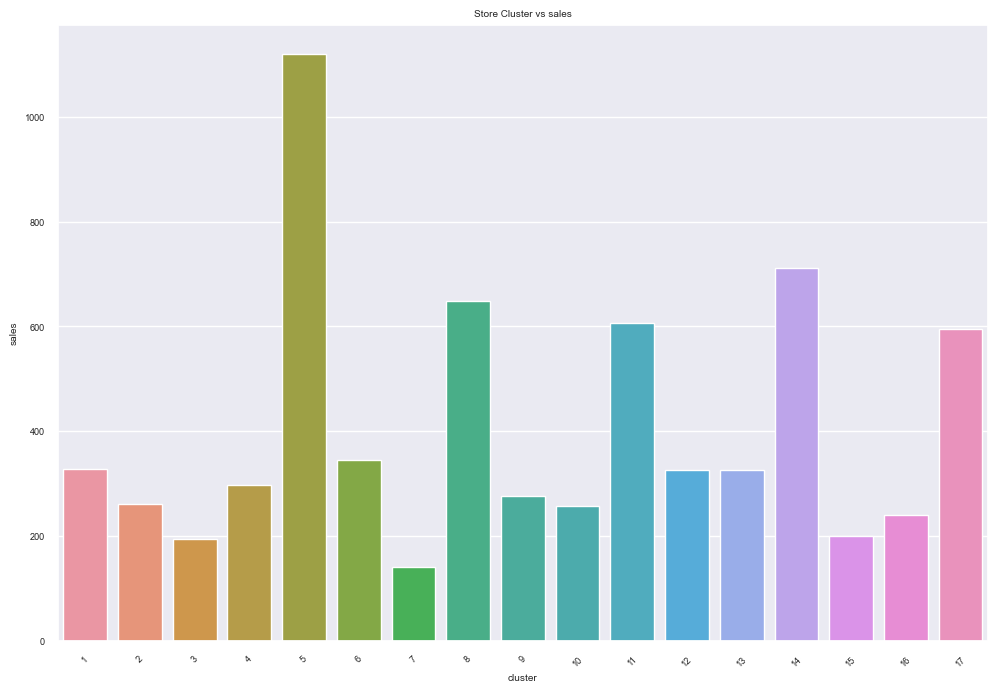

In [ ]:
#cluster is a grouping of similar stores.
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'cluster', y = 'sales', ci = None)
plt.title("Store Cluster vs sales")
plt.xticks(rotation = 45)

c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33'),
  Text(33, 0, '34'),
  Text(34, 0, '35'),
  Text(35, 0, '36'),
  Text(36, 0,

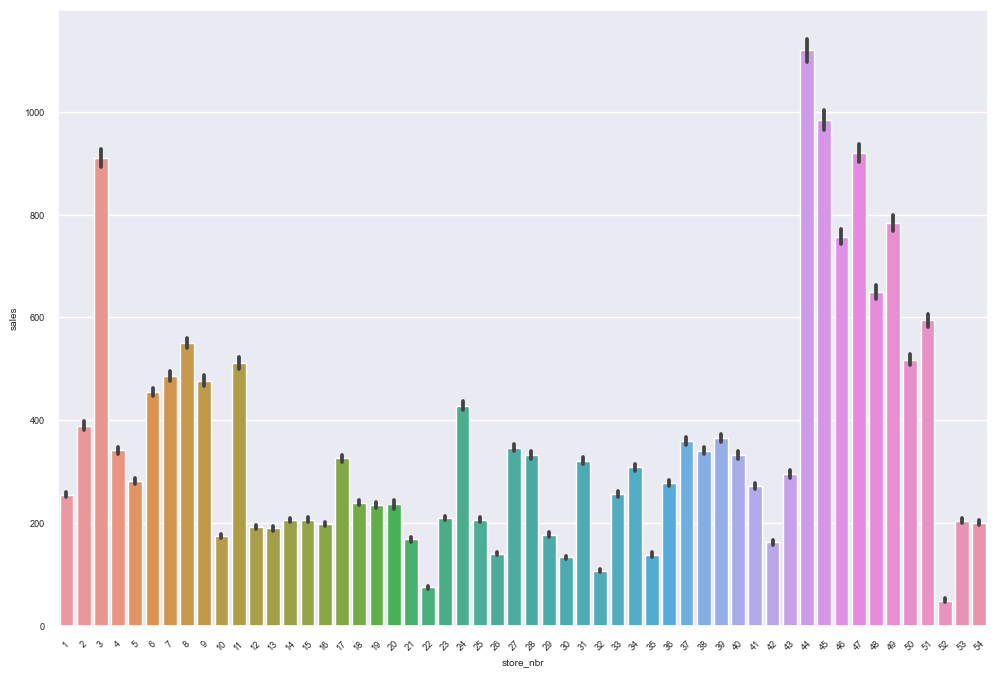

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'store_nbr', y = 'sales')
plt.xticks(rotation = 45)
plt.title("store number vs sales")

c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22')])

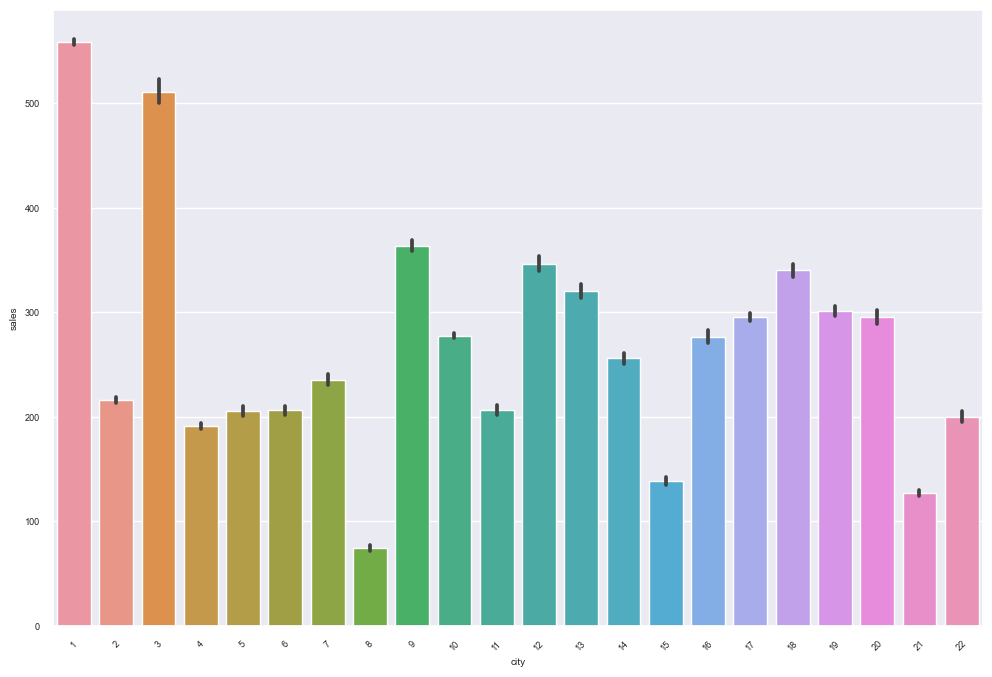

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'city', y = 'sales')
plt.xticks(rotation = 45)
plt.title("City vs Sales")
plt.show()

c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Eric\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33')])

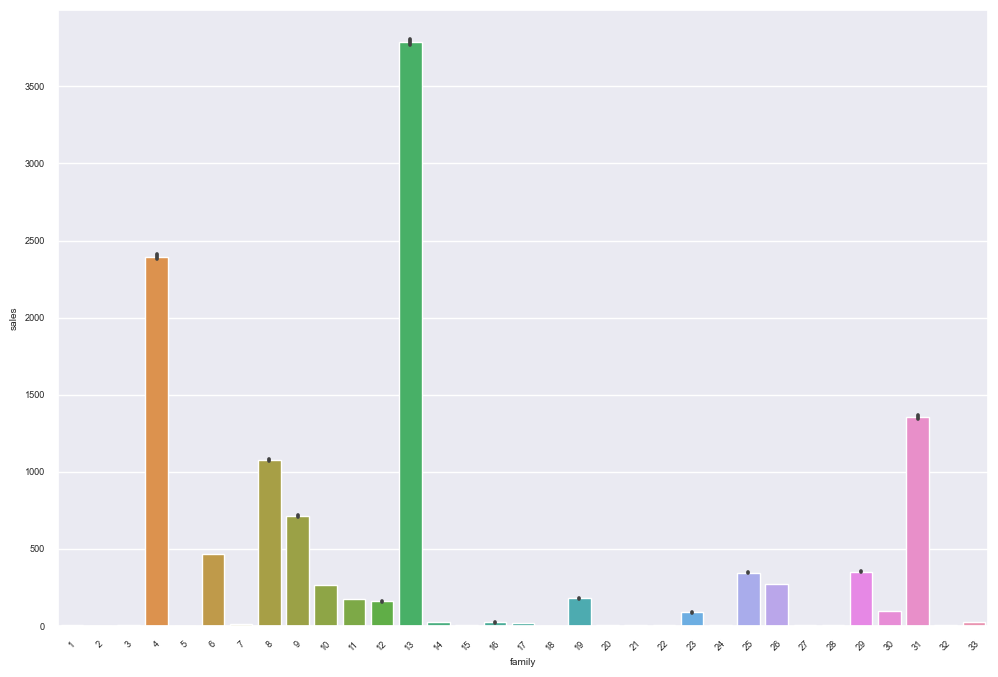

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = training, x = 'family', y = 'sales')
plt.xticks(rotation = 45)

Information we have discovered: 
Groceries have the most sales out of all families of products throughout all the Favorita stores,
Quito (The Capital of Ecuador) has the most sales compared to any other city in Ecuador,
Additional holiday days have the most sales,
A cluster of 5 stores has the most sales,
National Locale sells the most out of Local, regional and national,
Sales have increased over the years from 2013 - 2017,
Higher oil prices have shown lower sales and lower oil prices have shown higher sales,

Preparing training and testing data

In [ ]:
training['date']=training['date'].str.replace('-','')
training['date']=training['date'].astype(int)

In [ ]:
training = training.fillna(0)
training.isnull().sum()

In [ ]:
#Removing unnecessary columns like state description and transferred as city is more descriptive than state and transferred is less descriptive than holiday type
x_train = training.drop(['sales'], axis=1)
x_train = x_train.drop(['state'], axis=1)
x_train = x_train.drop(['description'], axis=1)
x_train = x_train.drop(['transferred'], axis=1)
x_train.head()